# Comparing Dense vs. SVD Retrieval
**Author:** Hai Ran Zheng

**Date:** March 14th, 2025

**Description:** 
Compare train time, inference time, and quality of SVD and Dense Embedding Retrieval

# Imports

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import pandas as pd
import numpy as np
import re
import os
import sys
sys.path.append("..")
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import nltk
from typing import Literal, Union
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# # check to see if the nltk data has been downloaded in the virtual environment
# if not os.path.exists(os.path.join(os.path.expanduser("~"), "nltk_data")):
    # download the nltk data
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [31]:
if ".." not in sys.path:
    sys.path.append("..")
from Experiments.preprocessing import Preprocesser
from Experiments.svd import TextClassifier
from Experiments.all_minilm import HuggingFaceClassifier
from helpers.utilities import (
    generate_word_frequencies_from_column
)

# Utilities/Setup

In [32]:
def left_align(df: pd.DataFrame):
    '''
        Apply left text-align 
    '''
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

In [33]:
pd.set_option('max_colwidth', 400)

In [34]:
# Matplotlib custom config
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.alpha"] = "0.2"
plt.rcParams["grid.linestyle"] = "-."

# Setup Dataset

In [35]:
PARENT_DIR = os.getcwd().rsplit(os.sep, maxsplit=1)[0]
DATASET_DIR = os.path.join(PARENT_DIR, "Datasets")

In [36]:
df = pd.read_csv(f"{DATASET_DIR}/test_agg.csv")

C:\Users\harri\AppData\Local\Temp\ipykernel_47184\3987571657.py:1: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{DATASET_DIR}/test_agg.csv")


In [37]:
df["IS_COMPLAINT"].value_counts()

IS_COMPLAINT
False    25742
True     11616
Name: count, dtype: int64

# EDA

### Haphazard Checks

In [ ]:
df.isnull().sum()["CDESCR"]

np.int64(1)

I'm surprised NaN exist

In [ ]:
df.loc[
    df["CDESCR"].isnull(),
    ["IS_COMPLAINT", "CDESCR"]
]

,IS_COMPLAINT,CDESCR
3926,True,NaN


In [ ]:
df.columns.sort_values()

Index(['ANTI_BRAKES_YN', 'BGMAN', 'CAMPNO', 'CDESCR', 'CITY', 'CMPL_TYPE',
       'COMPDESC', 'CONSEQUENCE_DEFECT', 'CORRECTIVE_ACTION', 'CRASH',
       'CRUISE_CONT_YN', 'DATEA', 'DEALER_CITY', 'DEALER_NAME', 'DEALER_STATE',
       'DEALER_TEL', 'DEALER_ZIP', 'DEATHS', 'DESC_DEFECT', 'DOT',
       'DRIVE_TRAIN', 'ENDMAN', 'FAILDATE', 'FIRE', 'FMVSS', 'FUEL_SYS',
       'FUEL_TYPE', 'INFLUENCED_BY', 'INJURED', 'IS_COMPLAINT', 'LDATE',
       'LOC_OF_TIRE', 'MAKETXT', 'MANUF_DT', 'MEDICAL_ATTN', 'MFGCAMPNO',
       'MFGTXT', 'MFR_COMP_DESC', 'MFR_COMP_NAME', 'MFR_COMP_PTNO', 'MFR_NAME',
       'MILES', 'MMYTXT', 'MODELTXT', 'NOTES', 'NUMRECORDS', 'NUM_CYLS',
       'OCCURENCES', 'ODATE', 'ODINO', 'ORIG_EQUIP_YN', 'ORIG_OWNER_YN',
       'POLICE_RPT_YN', 'POTAFF', 'PROD_TYPE', 'PURCH_DT', 'RCDATE',
       'RCLTYPECD', 'RCL_CMPT_ID', 'RECORD_ID', 'REPAIRED_YN',
       'RESTRAINT_TYPE', 'RPNO', 'SEAT_TYPE', 'STATE', 'TIRE_FAIL_TYPE',
       'TIRE_SIZE', 'TRANS_TYPE', 'Unnamed: 0', 'VEHICLE

In [ ]:
df.loc[
    df["CDESCR"].isnull(),
    ["RECORD_ID", "ODINO"]
]

,RECORD_ID,ODINO
3926,NaN,"11637459, 11641533, 11643067, 11644534"


Most likely empty string complaints here

In [ ]:
df.loc[
    df["CDESCR"].str.len() < 10,
    ["IS_COMPLAINT", "CDESCR"]
]

,IS_COMPLAINT,CDESCR
851,True,Unknown
4976,True,Recall .
5302,True,UNKNOWN
5342,True,UNKOWN
5676,True,12
6201,True,ewfsdfds
6438,True,M
7996,True,Oil leak
9252,True,unknown
11222,True,Fuse box


### Word Count Distribution

In [ ]:
df["CDESCR"].str.len().describe()

count    37357.000000
mean       479.646653
std        306.906863
min          1.000000
25%        297.000000
50%        415.000000
75%        568.000000
max       2375.000000
Name: CDESCR, dtype: float64

### Word Intersects and Diffs

In [ ]:
all_freq = generate_word_frequencies_from_column(
    df, "CDESCR"
)

In [ ]:
complaint_word_freq = generate_word_frequencies_from_column(
    df[df["IS_COMPLAINT"] == 1], "CDESCR"
)

In [ ]:
recall_word_freq = generate_word_frequencies_from_column(
    df[df["IS_COMPLAINT"] == 0], "CDESCR"
)

In [ ]:
len(all_freq)

34261

In [ ]:
dataset_intersect = pd.Series(
    np.intersect1d(recall_word_freq.index, complaint_word_freq.index)
)

In [ ]:
all_intersect_freqs = all_freq[all_freq.index.isin(dataset_intersect)]

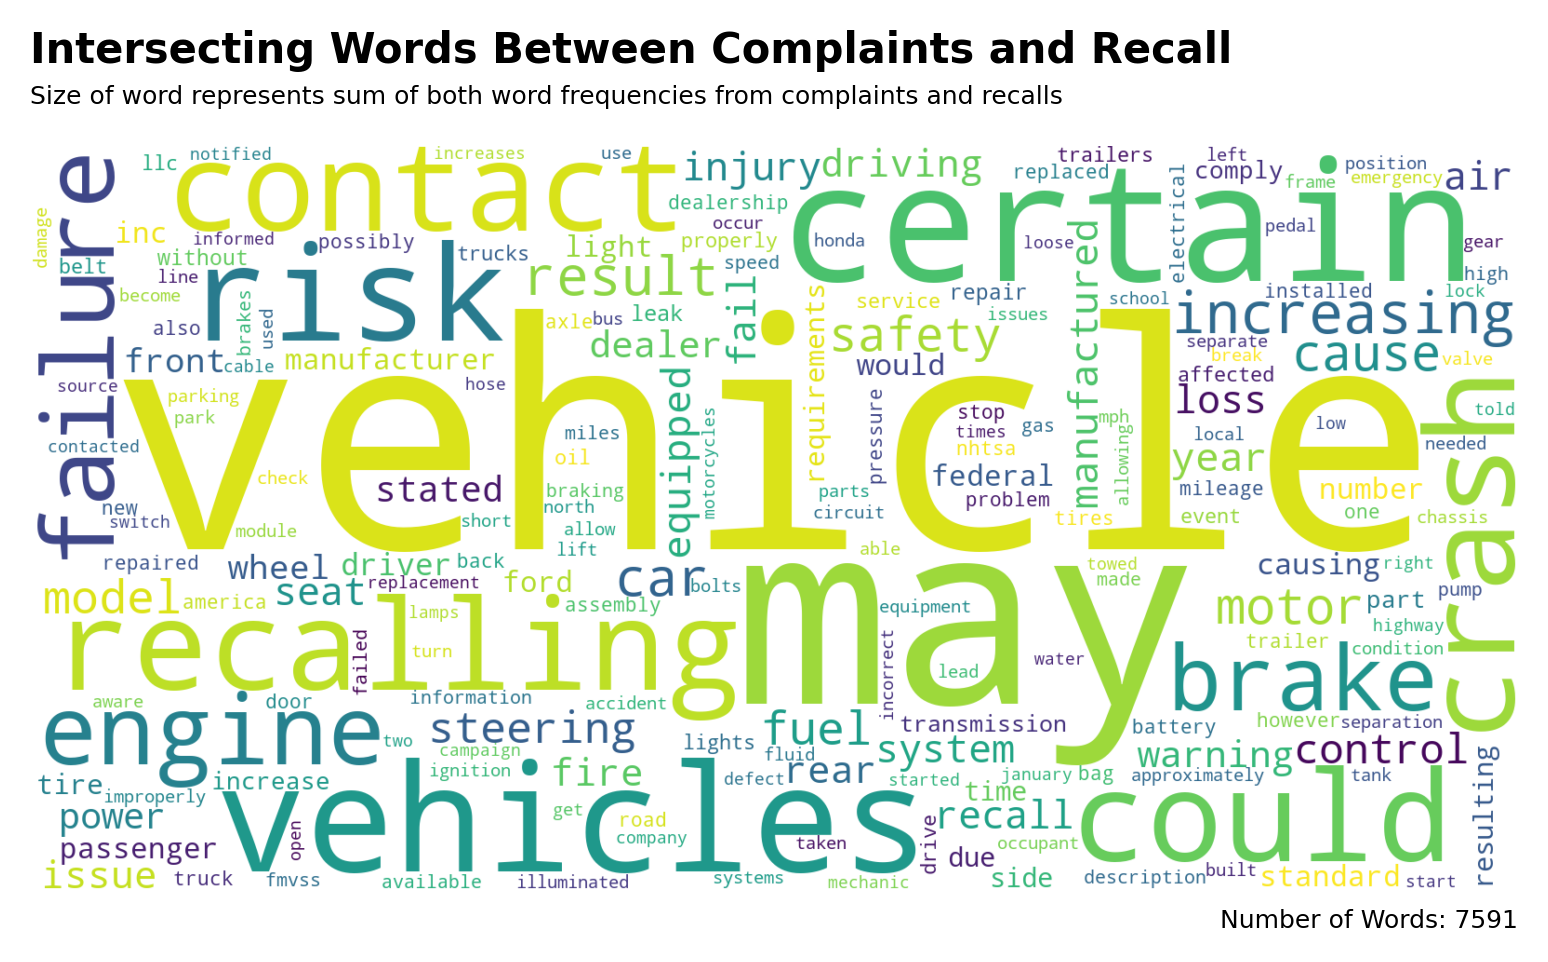

In [ ]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(all_intersect_freqs.to_dict()['count'])
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.suptitle('Intersecting Words Between Complaints and Recall', x=0, y=1.1, va="bottom",
                 ha="left", fontsize=10, fontweight=900, transform=ax.transAxes)
_ = plt.title("Size of word represents sum of both word frequencies from complaints and recalls", 
              x=0, y=1.05, ha="left", va="bottom", fontsize=6, transform=ax.transAxes)
_ = plt.text(s=f"Number of Words: {len(dataset_intersect)}", x=1, y=-0.05, ha="right", transform=ax.transAxes,
         fontsize=6)

Top difference in frequency for intersecting words

In [ ]:
complaint_intersect_freqs = complaint_word_freq[
    complaint_word_freq.index.isin(dataset_intersect)
]

In [ ]:
recall_intersection_freqs = recall_word_freq[
    recall_word_freq.index.isin(dataset_intersect)
]

In [ ]:
compare_intersect_freqs = pd.merge(
    complaint_intersect_freqs,
    recall_intersection_freqs,
    left_index=True,
    right_index=True,
    suffixes=("_complaint", "_recall")
)

In [ ]:
compare_intersect_freqs

,count_complaint,count_recall
CDESCR,,
vehicle,17824,19405
contact,13077,1599
failure,8940,2700
car,7990,404
engine,7045,4356
...,...,...
bores,1,3
distinguish,1,2
spline,1,42


### Largest Word Count Difference where there are more complaint than recall

In [ ]:
compare_intersect_freqs["more_complaint_than_recall"] = (
    compare_intersect_freqs["count_complaint"] - compare_intersect_freqs["count_recall"]
)
complaint_more_than_recall = compare_intersect_freqs[
    compare_intersect_freqs["more_complaint_than_recall"] >= 0
]

In [ ]:
complaint_more_than_recall["more_complaint_than_recall"].sort_values(ascending=False).head(10)

CDESCR
contact         11478
car              7586
failure          6240
dealer           5646
issue            5640
stated           5284
recall           5189
driving          4281
manufacturer     4219
repair           3075
Name: more_complaint_than_recall, dtype: int64

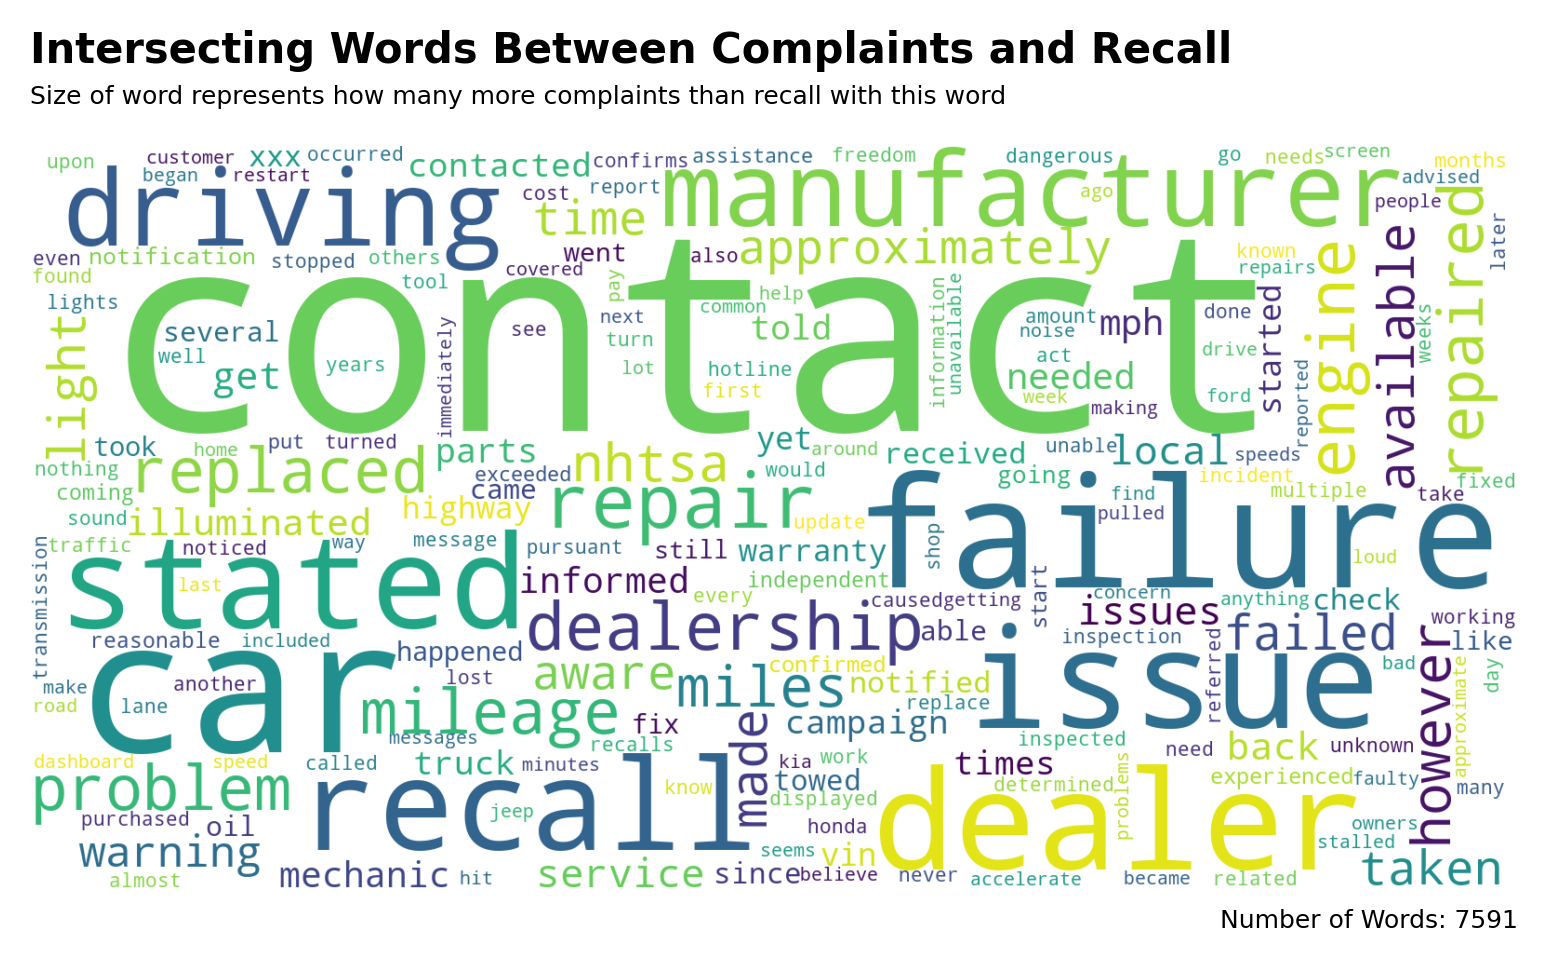

In [ ]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(
                    complaint_more_than_recall.to_dict()["more_complaint_than_recall"]
    
                )
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.suptitle('Intersecting Words Between Complaints and Recall', x=0, y=1.1, va="bottom",
                 ha="left", fontsize=10, fontweight=900, transform=ax.transAxes)
_ = plt.title("Size of word represents how many more complaints than recall with this word", 
              x=0, y=1.05, ha="left", va="bottom", fontsize=6, transform=ax.transAxes)
_ = plt.text(s=f"Number of Words: {len(dataset_intersect)}", x=1, y=-0.05, ha="right", transform=ax.transAxes,
         fontsize=6)

In [ ]:
compare_intersect_freqs["more_recall_than_complaint"] = (
    compare_intersect_freqs["count_recall"] - compare_intersect_freqs["count_complaint"]
)
recall_more_than_complaint = compare_intersect_freqs[
    compare_intersect_freqs["more_recall_than_complaint"] >= 0
]

In [ ]:
recall_more_than_complaint["more_recall_than_complaint"].sort_values(ascending=False).head(10)

CDESCR
may           28948
certain       19294
vehicles      15601
recalling     14897
crash         14100
risk          13919
could         10766
increasing     9151
result         8110
motor          7107
Name: more_recall_than_complaint, dtype: int64

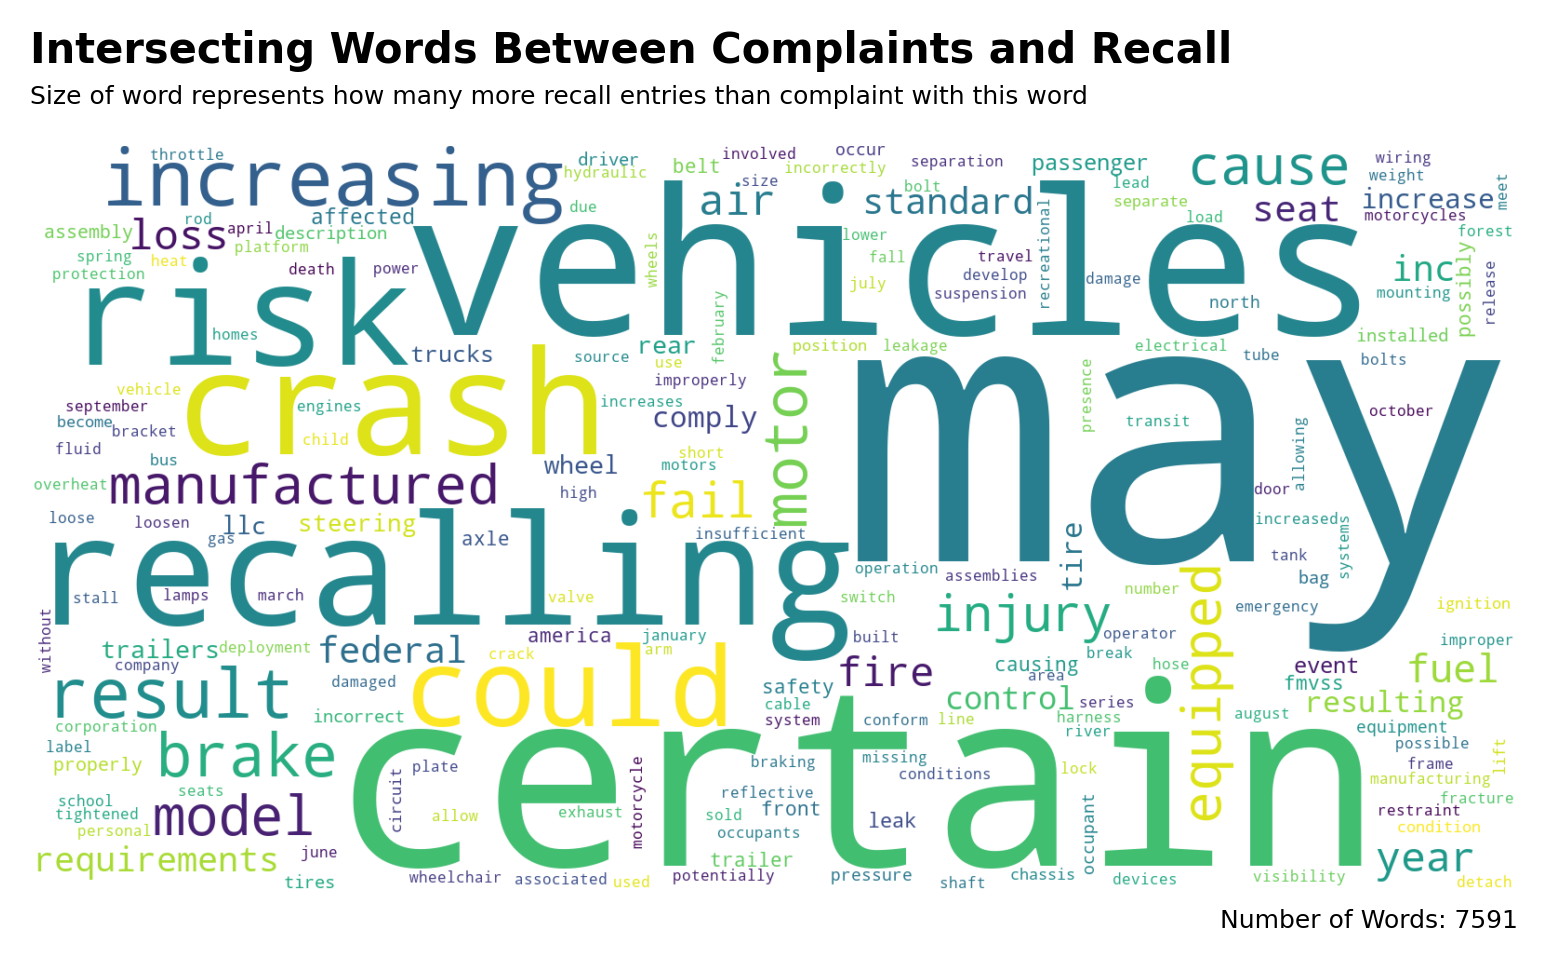

In [ ]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(
                    recall_more_than_complaint.to_dict()["more_recall_than_complaint"]
    
                )
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.suptitle('Intersecting Words Between Complaints and Recall', x=0, y=1.1, va="bottom",
                 ha="left", fontsize=10, fontweight=900, transform=ax.transAxes)
_ = plt.title("Size of word represents how many more recall entries than complaint with this word", 
              x=0, y=1.05, ha="left", va="bottom", fontsize=6, transform=ax.transAxes)
_ = plt.text(s=f"Number of Words: {len(dataset_intersect)}", x=1, y=-0.05, ha="right", transform=ax.transAxes,
         fontsize=6)

### Difference

In [ ]:
words_complaint = set(complaint_word_freq.index.tolist())
words_recall = set(recall_word_freq.index.tolist())

# Words only in complaint
unique_complaint = words_complaint - words_recall

In [ ]:
complaint_diff = all_freq[all_freq.index.isin(unique_complaint)]

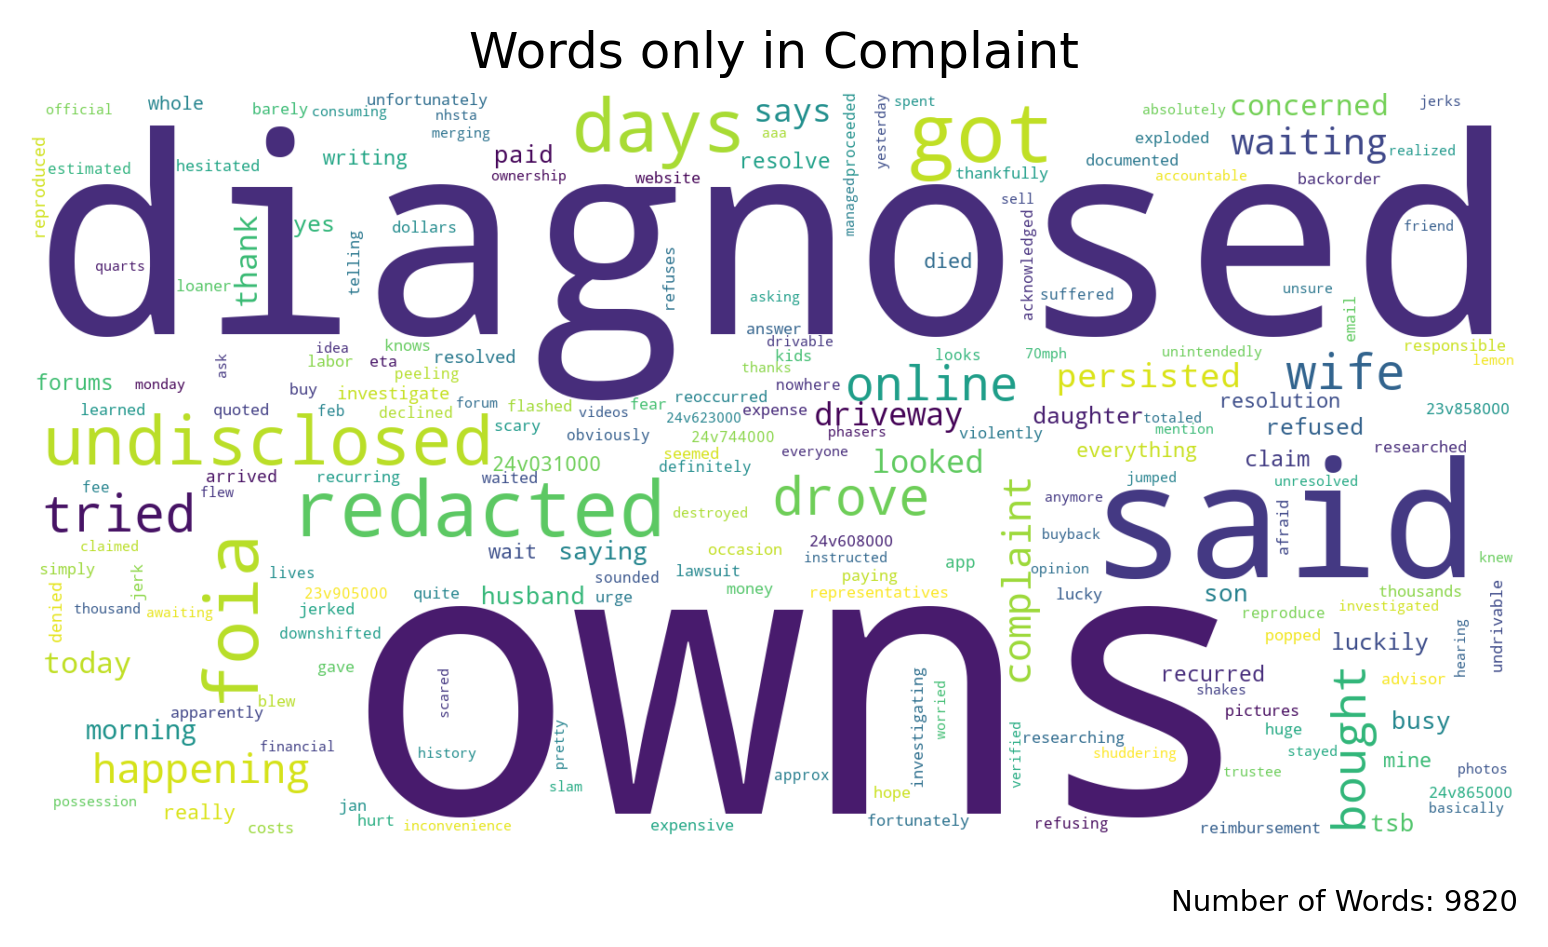

In [ ]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(complaint_diff.to_dict()['count'])
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.text(s=f"Number of Words: {len(complaint_diff)}", x=1, y=-0.1, ha="right", transform=ax.transAxes,
         fontsize=7)
plt.margins(x=0, y=0)
_ = plt.title('Words only in Complaint')

In [ ]:
words_complaint = set(complaint_word_freq.index.tolist())
words_recall = set(recall_word_freq.index.tolist())

# Words only in recall
unique_recall = words_recall - words_complaint

In [ ]:
recall_diff = all_freq[all_freq.index.isin(unique_recall)]

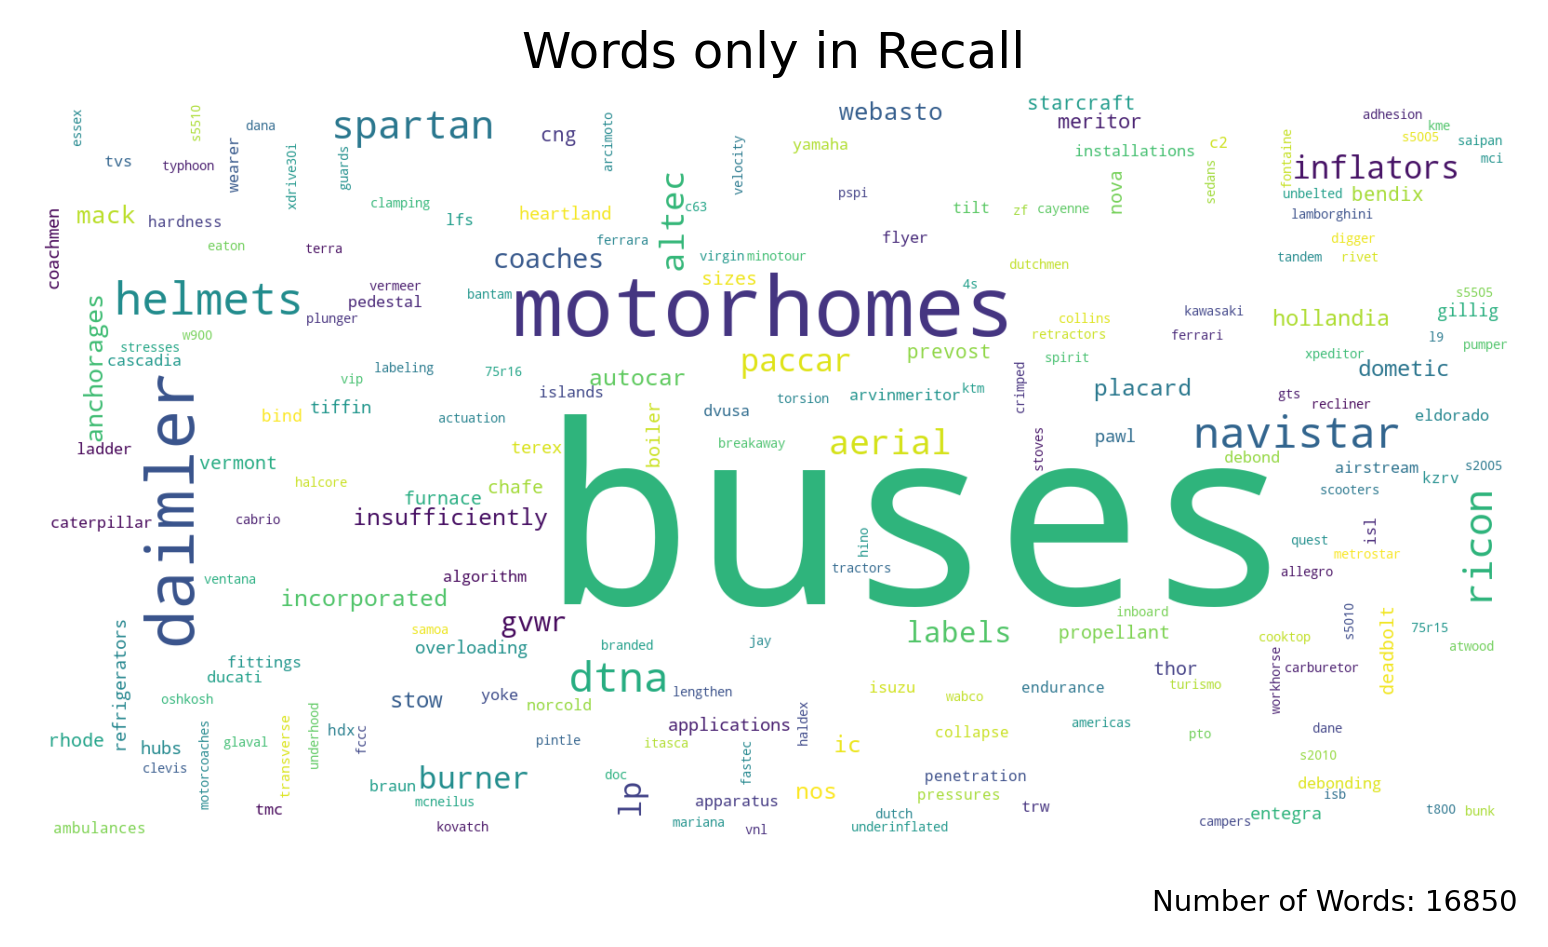

In [ ]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(recall_diff.to_dict()['count'])
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.text(s=f"Number of Words: {len(recall_diff)}", x=1, y=-0.1, ha="right", transform=ax.transAxes,
         fontsize=7)
plt.margins(x=0, y=0)
_ = plt.title('Words only in Recall')

## Sentence-Level Analysis (Recall)

# List of Queries For Testing
<div style="font-size:20px;font-weight:700">
    Direct Vehicle Issues
</div>

- Speaker rattles
- Clicking sound steering left and right
- Brake lamps stay on
- Air bag issues from faulty sensor
- Bad smell can be observed due to break pads overheating.
- Overheating can be observed due to power train issues.
- Door open/close issues can be observed due to door latch issue, child safety mode malfunctions.
- Harsh clutch movements can be observed due to transmission/powertrain issues.
- Steering wheel issues can be observed due to unbalanced tires.
- Seat adjustment issues can be observed due to debri in seat latch.
- Light issues can be observed due to faulty electrical sensors.

 - **Latch** is an interesting one, as well as **axle**, since it could refer to different parts of a vehicle.


# SVD Retrieval

1. Convert Documents into TF-IDF vector
2. Train Scikit-Learn's SVD algorithm on train set
3. Retrieve relevant documents given query
4. Show relevant topics

In [ ]:
clf_svd = TextClassifier(f'{DATASET_DIR}/test_agg.csv', column_name='CDESCR', svd_n_dimensions=384)

In [ ]:
_ = clf_svd.run_training_pipeline(
    subgroup="svd_384_base"
)


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Example\..\Experiments\svd.py:61: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(self.dataset_path)


In [ ]:
len(clf_svd.df_train)

26150

## Training Time

2 minute 10 second training time for 26444 documents. That's about 26644/130 = 205 documents per second on my computer. Here are my computer specs:

In [ ]:
!cpuinfo

Python Version: 3.12.7.final.0 (64 bit)
Cpuinfo Version: 9.0.0
Vendor ID Raw: AuthenticAMD
Hardware Raw: 
Brand Raw: AMD Ryzen 5 8640HS w/ Radeon 760M Graphics
Hz Advertised Friendly: 3.4930 GHz
Hz Actual Friendly: 3.5010 GHz
Hz Advertised: (3493000000, 0)
Hz Actual: (3501000000, 0)
Arch: X86_64
Bits: 64
Count: 12
Arch String Raw: AMD64
L1 Data Cache Size: 
L1 Instruction Cache Size: 
L2 Cache Size: 6291456
L2 Cache Line Size: 1024
L2 Cache Associativity: 6
L3 Cache Size: 16777216
Stepping: 2
Model: 117
Family: 25
Processor Type: 
Flags: 3dnow, 3dnowext, 3dnowprefetch, abm, adx, aes, apic, avx, avx2, avx512bitalg, avx512bw, avx512cd, avx512dq, avx512f, avx512ifma, avx512vbmi, avx512vbmi2, avx512vl, avx512vnni, avx512vpopcntdq, bmi1, bmi2, clflush, clflushopt, clwb, cmov, cmp_legacy, cr8_legacy, cx16, cx8, de, dts, erms, f16c, fma, fpu, fxsr, gfni, ht, hypervisor, ia64, invpcid, lahf_lm, mca, mce, misalignsse, mmx, monitor, movbe, msr, mtrr, osvw, osxsave, pae, pat, pclmulqdq, perfctr_c

Ignore python version as it is my global python version. I'm using a venv that has a different python version (3.10.16)

## Grade

Overall grade:
1. Excellent Training Time even on CPU: ~205 documents per Second
2. Fast Inference: ~150ms. For 1 million documents, this is not very fast (~41 hours)
3. Some topics not covered (e.g. does not understand what 'bad smell' or 'overheating' is), but it is able to capture semantic relationships (query "speaker rattles" does uncover car radio problems).

Another problem is that complaints information is more specific to a vehicle issue than recall information, which may mention more things such as class of vehicle. 

# Dense Embedding Retrieval

1. Convert documents into vector embeddings (e.g. All-MiniLM for general purpose embeddings, or use Roberta for more semantic embeddings)
2. Split documents into chunks and store in vector index/database. 
3. Send query to vector database

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

In [ ]:
hg = HuggingFaceClassifier(
    dataset_path=f"{DATASET_DIR}\\test_agg.csv",
    model_name="all-MiniLM-L6-v2",  
    column_name="CDESCR",   
    similarity_fn_name="cosine"
)
hg.run_training_pipeline()
returned_docs = hg.query_embeddings(
    query="Car won't start and makes a clicking noise",
    top=50
)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Example\..\Experiments\all_minilm.py:21: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(self.dataset_path)


Embeddings found. Loading embeddings.


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Example\..\Experiments\all_minilm.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs_to_return["similarity"] = values.squeeze()


## Grade

# Compare Docs

In [ ]:
def compare_docs(query, method : Literal["svd", "all-minilm"],
                 subgroup=None,
                 column_name="CDESCR",
                 keep : Literal[
                    "complaint",
                    "recall",
                    "all"
                ] = "all",
                 top=10,
                 columns=["Unnamed: 0", "CDESCR", "similarity", "IS_COMPLAINT"]):
    if method == "all-minilm":
        hg = HuggingFaceClassifier(
            dataset_path=f"{DATASET_DIR}\\test_agg.csv",
            model_name="all-MiniLM-L6-v2",  
            column_name=column_name,   
            similarity_fn_name="cosine"
        )
        hg.run_training_pipeline()
        returned_docs = hg.query_embeddings(
            query=query,
            keep=keep,
            top=top,
        )
    elif method == "svd":
        clf_svd = TextClassifier(
            f'{DATASET_DIR}/test_agg.csv', 
            column_name=column_name, 
            svd_n_dimensions=384
        )
        _ = clf_svd.run_training_pipeline(
            subgroup=subgroup
        )
        returned_docs = clf_svd.find_similar(
            query_text=query,
            dataset_to_check="train",
            keep=keep,
            top=top
        )

    returned_docs["CDESCR"] = returned_docs["CDESCR"].str.lower()
    final_rows = returned_docs[columns].head(top)
    return final_rows
    # return final_rows.style.hide()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
all_mini_lm_top_20 = compare_docs(
    query="shudder with hard shifting",
    method="all-minilm",
    top=40
)

Embeddings found. Loading embeddings.


In [ ]:
svd_top_20

,Unnamed: 0,CDESCR,similarity,IS_COMPLAINT
15814,3026,hard shifting,0.995590,True
25075,1762,vehicle has hard shifting up and down. loud clank when up shifting or down shifting at random times.,0.899628,True
25865,784,jark sometimes when shifting it self,0.808684,True
23702,7230,vehicle jumps when shifting gears. when coming to a stop it jumps forward. hard shifting.,0.783518,True
2472,696,transmission shifts really hard and down shift hard. have been the to dearships 3 times being told that’s just how the transmission is even them acknowledging. it’s a problem.,0.769886,True
14362,5036,transmission jerks with hard shift and rough idle,0.769521,True
23609,6796,10 speed transmission has started shifting hard at times and is random when it occurs. at times the hard shift comes with some stuttering under normal acceleration.,0.736555,True
11307,1180,"consistent hard, sudden shifts, jerking, shaking, and shuddering during gear changes. the vehicle also stalls and experiences shift delays. the vehicle also abruptly shifts to neutral while driving at various speeds.",0.735198,True
22386,11094,"shifting became erratic i lost 9th and 10th gears with hard shifts to 4th and 7th ,,ford dealer said it is cdf drum in tranny.. and it is just over 60000 and not covered..that is 8300 dollars out of my pocket.",0.698341,True
19910,755,vehicle is exhibiting harsh engagement and hard shifting. no warning lights. happens mainly between between 0mph to 30 mph. can feel the car jerk. ford dealer confirmed hard shifts and jerking and found the issue with the torque convertor. recommend transmission replacement. car was only at 68k miles.,0.674898,True


In [ ]:
all_mini_lm_top_20

,Unnamed: 0,CDESCR,similarity,IS_COMPLAINT
8230,8230,hard shifting and shuddering,0.825183,True
2832,2832,"automobile shudders horribly on first gear and shifting from first to second gear. attempted repair, however in time the shuddering came back. then downshifting to go up a steep incline transmission made grinding/ticking noise. experienced too much anxiety driving, got rid of the car.",0.736750,True
3026,3026,hard shifting,0.692090,True
7042,7042,there is a shudder and whining noise with confused shifting gears behavior.,0.655930,True
2797,2797,transmission has a hard shift when coming out of each gear. 2nd to 1st shifts hard and jolts entire vehicle a head. feels like a slip or difficulty in shift.,0.637467,True
8239,8239,transmission slips going into 1st. then when it shifts to the next gears it shudders. it is available for inspection but i have not taken it to a service center. no lamps and messages are present.,0.601730,True
4897,4897,"hard shifting when accelerating/decerating, jerking of the car due to transmission issues (80k miles), abs/braking issues due to engine components not being in sync, etc",0.600373,True
6994,6994,transmission is shifting rough,0.587366,True
5036,5036,transmission jerks with hard shift and rough idle,0.586090,True
5003,5003,"i have started noticing rough shifting, delayed engagement, harsh shifts, and sometimes even slipping between gears. have taken to the dealership and it is needing a whole new transmission",0.579674,True


In [ ]:
svd_top_20 = compare_docs(
    query="shudder with hard shifting",
    method="svd",
    subgroup="svd_384_base",
    top=40
)

In [ ]:
all_mini_lm_top_20.loc[all_mini_lm_top_20["Unnamed: 0"].isin(svd_top_20["Unnamed: 0"])]

,Unnamed: 0,CDESCR,similarity,IS_COMPLAINT
3026,3026,hard shifting,0.692090,True
5036,5036,transmission jerks with hard shift and rough idle,0.586090,True
5003,5003,"i have started noticing rough shifting, delayed engagement, harsh shifts, and sometimes even slipping between gears. have taken to the dealership and it is needing a whole new transmission",0.579674,True
6196,6196,"suddenly losing power, shifting hard, slipping between gears, causing shuddering while driving, and surging forward while accelerating.",0.576626,True
6796,6796,10 speed transmission has started shifting hard at times and is random when it occurs. at times the hard shift comes with some stuttering under normal acceleration.,0.572930,True
1919,1919,steering jerks sometimes transmission would not go into gear just raves up and then there’s times when it drive normal transmission bangs shifts hard stutters late shift driver assist blocked,0.558052,True
1180,1180,"consistent hard, sudden shifts, jerking, shaking, and shuddering during gear changes. the vehicle also stalls and experiences shift delays. the vehicle also abruptly shifts to neutral while driving at various speeds.",0.538608,True
9474,9474,"when the vehicle is cold, and the transmission has not yet warmed up, putting the truck into gear results in a significant jerk. specifically: initial gear engagement (drive/reverse): when shifting into either drive or reverse from park, especially when the engine is cold, there is a noticeable delay before the gear engages. this delay is followed by a harsh ""jerk"" or ""thud"" as the gear final...",0.525181,True
755,755,vehicle is exhibiting harsh engagement and hard shifting. no warning lights. happens mainly between between 0mph to 30 mph. can feel the car jerk. ford dealer confirmed hard shifts and jerking and found the issue with the torque convertor. recommend transmission replacement. car was only at 68k miles.,0.508108,True
1762,1762,vehicle has hard shifting up and down. loud clank when up shifting or down shifting at random times.,0.505687,True


In [ ]:
all_mini_lm_top_20["Unnamed: 0"].isin(svd_top_20["Unnamed: 0"]).sum()/len(all_mini_lm_top_20)

np.float64(0.3)

In [ ]:
compare_docs(
    query="bad smell brake pads overheating",
    method="svd",
    subgroup="svd_384_base"
)

,Unnamed: 0,CDESCR,similarity,IS_COMPLAINT
625,15382,"there is inadequate clearance between the front disc pads and the caliper assembly. heat build up can cause the brake pad backing plate to expand and bind in the caliper. the brake pads will continuously contact the brake rotor, overheating the front rotor.\r\nthe expansion of the brake pad backing plate will causethe brake pads to continuously contact the brake rotor and overheat the frontrot...",0.694829,False
9381,31161,"brembo s.p.a. (brembo) is recalling certain federal mogul rear brake pads. during braking, the brake pad material may detach from the back plate, which can affect the braking performance in slowing the vehicle.\r\nif the brake pad friction material detaches it can, inhibit braking ability, increasing the risk of injury and crash.",0.652711,False
19406,574,vehicle has had 3 instances of a feeling of locking/ seizing and shutter or hesitation during braking at 40 to 65 mph. service light appear about brake system which quickly vanishes in less than few seconds same as feeling of the brake seizing also disappears within few seconds. this occurred from initial purchase to date at 21k miles. vehicle brake system inspected at this service junction 2 ...,0.594575,True
20900,33028,"genuine scooters, llc. (genuine scooters) is recalling certain 2020 royal alloy gt150 scooters. the front brake rotor may become uncentered within the front brake caliper allowing the inner brake pad to dislodge from the top of the brake caliper.\r\nif the brake pad becomes dislodged, the scooter can experience a reduced or complete loss of braking, increasing the risk of a crash.",0.579921,False
23686,32808,"brembo s.p.a (brembo) is recalling certain brembo brake pads, model brm10b, part number 07988236/07b80923. the tungaloy pads could corrode, and potentially cause detachment of the brake pad friction material from the backing plate.\r\nif the brake pad friction material detaches from the backing plate, it may lengthen the stopping distance needed, increasing the risk of a crash.",0.560229,False
16157,33483,"ktm north america, inc. (ktm) is recalling certain 2022 husqvarna 350s and husqvarna 501s motorcycles. the brake pad retaining clips on the front brake caliper may have been mounted incorrectly, which could result in loose or detached front brake pads.\r\nloose or detached front brake pads can reduce braking performance, increasing the risk of a crash or injury.",0.551560,False
3101,10556,"after 22,207 mi, the right rear wheel unit started making a clunking similar to a flat tire. i looked online and found tsb 22-2023 which states that a common problem with the mach e one pedal driving is brake pad material gets fused to the rotor. i took it in for repair and the brakes are out of warranty after 18000mi. average life of brake rotors for cars that use their brakes is 30,000-70,00...",0.549214,True
2662,14206,"a hydraulic brake line and/or brake pad is missing in either the primary or secondary system.\r\nshould a brake line or brake pad be missing, it can cause the vehicle to pull to the right or left when apply the brakes resulting in a significant increase in vehicle stopping distance.",0.538561,False
7047,35140,"hendrickson usa, l.l.c. (hendrickson) is recalling certain vantraax trailer slider suspension and axle assemblies with part number vantraax.34502, equipped with haldex brake modult gen ii air disc brakes. the retaining clip in the brake pad retaining assembly may be loose or could detach, loosening the brake pad.\r\na retaining clip or bracket that detaches can damage the brake pad, reducing ...",0.531843,False
20309,14130,"equipment description: aftermarket disc brake pads used as replacement products for 1983-1985, 1987-1994 ford rangers, 1984-1985, 1987-1990 bronco ii, 1986-1997 aerostar mini vans, 1991-1994 explorer, and 1991-1994 mazda navajo sport utility vehicles. the locating lugs on the steel back of the outer brake pad were incorrectly positioned.\r\nthe out

In [ ]:
compare_docs(
    query="bad smell brake pads overheating",
    method="all-minilm"
)

Embeddings found. Loading embeddings.


Unnamed: 0,CDESCR,similarity,IS_COMPLAINT
15382,"THERE IS INADEQUATE CLEARANCE BETWEEN THE FRONT DISC PADS AND THE CALIPER ASSEMBLY. HEAT BUILD UP CAN CAUSE THE BRAKE PAD BACKING PLATE TO EXPAND AND BIND IN THE CALIPER. THE BRAKE PADS WILL CONTINUOUSLY CONTACT THE BRAKE ROTOR, OVERHEATING THE FRONT ROTOR. THE EXPANSION OF THE BRAKE PAD BACKING PLATE WILL CAUSETHE BRAKE PADS TO CONTINUOUSLY CONTACT THE BRAKE ROTOR AND OVERHEAT THE FRONTROTOR; CAUSING THE FRONT BRAKE ROTOR TO DISTORT, DECREASING BRAKE PERFORMANCEAND CAUSING LONGER STOPPING DISTANCES WHICH COULD RESULT IN AN ACCIDENT.",0.554119,False
17322,CERTAIN REAR BRAKE CALIPERS COULD BIND AND CONSEQUENTLY OVERHEAT. OVERHEATED CALIPERS COULD CAUSE BRAKE PEDAL TO FEELSPONGY AND COULD RESULT IN ONE BRAKE CIRCUIT BECOMING INOPERATIVE. BRAKINGABILITY WOULD BE AFFECTED.,0.528510,False
15073,"BRAKE LINES IN THE ENGINE COMPARTMENT ARE ROUTED TOO NEAR THE LEFT EXHAUST MANIFOLD, CAUSING THE BRAKE FLUID TO OVERHEAT. BRAKE FLUID LOSES VISCOSITY WHEN IT OVERHEATS, CAUSINGLOSS OF BRAKES OR INCREASED VEHICLE STOPPING DISTANCE WHICH MAY RESULT IN ANACCIDENT.",0.520700,False
20793,"CERTAIN MOTOR COACHES, MOTOR HOMES, COMMUTER COACHES, AND TRANSIT BUSES EQUIPPED WITH ARVIN-MERITOR DX 225 AIR DISC BRAKES, ARE EXPERIENCING EXCESSIVE SMOKE IN THE WHEEL AREA DUE TO OVERHEATING OF THE AIR DISC BRAKE PADS. A POTENTIAL FIRE IN THE WHEEL MAY OCCUR WHICH MAY RESULT IN PROPERTY DAMAGE OR PERSONAL INJURY.",0.516300,False
11918,"ON CERTAIN MOTOR HOMES, THE BRAKE ASSEMBLIES EXHIBIT ELEVATED TEMPERATURES THAT CAN LEAD TO CATASTROPHIC DETERIORATION OF THE WHEEL END COMPONENTS SUCH AS BEARINGS, RACES, SPINDLES, KNUCKLES, SEALS, HUBS, ROTORS, PATCH BOLTS, CALIPERS, BRAKE PADS, AND ABS SENSORS. THIS COULD RESULT IN LOSS OF CONTROL, AND/OR THE POTENTIAL FOR A FIRE.",0.487572,False
18213,"ON CERTAIN SHUTTLE BUS CHASSIS, THE BRAKE ASSEMBLIES EXHIBIT ELEVATED TEMPERATURES THAT CAN LEAD TO CATASTROPHIC DETERIORATION OF THE WHEEL END COMPONENTS SUCH AS BEARINGS, RACES, SPINDLES, KNUCKLES, SEALS, HUBS, ROTORS, PATCH BOLTS, CALIPERS, BRAKE PADS, AND ABS SENSORS. THIS COULD RESULT IN LOSS OF CONTROL, AND/OR THE POTENTIAL FOR A FIRE.",0.482620,False
1953,"My Jeep eats up thermostats too often. I have had it for 3 years and had it replaced 4 times. The last time , one year ago, it took the repair shop a week to finally install one that would hold. It needs it again. I also smell something burning when I accelerate onto the freeway since owning it. My engines fan runs high aIl the time also. I read many complaints online about people having overheating problems and temp fluctuations In the same year vehicle. This seems to be an issue and I can't afford to keep paying to have the thermostat replaced yearly. Last time last year they replaced the radiator with it since melted rubber around thermostat could of gotten into radiator cogging it. This jeep seems to be a lemon with all that has gone wrong since I bought it. I feel this issue needs to be looked into. I dont feel safe driving it anymore specially with the burning smell I get when I accelerate onto the freeway. It almost smells like wiring but not sure. It not a distinct smell. I entered only one incident that occurred with this issue as one is all I could submit. A few days ago was the recent but 2 more besides that. Thank you",0.480615,True
6285,Put new brake pads on car still having same problem brakes work fine most of the time. Then every now and then brake pads goes to floor (squeezy)then next day back working fine this is going to cause a accident.,0.475749,True
1013,Smell coming into cabin. Overwhelming to the point making us nauseous and sick. Taken it to Ford dealership. They can not mimic the issue.,0.474659,True
9316,"I have experienced a persistent brake vibration issue since I first acquired my 2024 Audi Q8 e-tron in December 2023. The vehicle has required two full brake rotor and pad replacements within 12,000 miles, which is highly abnormal and sugge

,Unnamed: 0,CDESCR,similarity,IS_COMPLAINT
13906,13906,"VEHICLE DESCRIPTION: PASSENGER VEHICLES. SOME AIR BAG SENSORS DO NOT COMPLY WITH AUDI'S DURABILITY STANDARDS OVER THE LIFETIME OF THE VEHICLE.\r\nIN THE EVENT THE SENSOR SHOULD MALFUNCTION, THE AIR BAG RESTRAINT SYSTEM CAN INADVERTENTLY DEPLOY. DEPLOYMENT OF THE AIR BAG RESTRAINT SYSTEM WITHOUT WARNING COULD CAUSE A DRIVER TO LOSE VEHICLE CONTROL.",0.728836,False
15730,15730,THE TWO AIR BAG SYSTEM FRONT IMPACT SENSORS MAY NOT BE SECURED TO THEIR MOUNTING BRACKETS.\r\nAIR BAG WILL NOT DEPLOY IN A FRONTAL COLLISION IF THEFRONT IMPACT SENSORS ARE NOT ATTACHED.,0.717320,False
32304,32304,"Toyota Motor Engineering & Manufacturing (Toyota) is recalling certain 2019 Sienna vehicles. The passenger front door may have incorrect welds inside, possibly affecting the air bag sensor readings for the passenger side front seat and curtain shield air bags.\r\nThe incorrect air bag sensor readings could cause the affected air bags to unintentionally deploy or to not deploy when intended, i...",0.708586,False
31166,31166,"Toyota Motor Engineering & Manufacturing (Toyota) is recalling certain 2016 Toyota Prius and Lexus RX 350, RX 350 F Sport, RX 450h F Sport and RX 450h vehicles and 2015-2016 Lexus NX 200T, NX Turbo and NX 300h vehicles. The air bag pressure sensors and/or the acceleration sensors may fail causing the side/curtain shield air bags and/or the front air bags to not deploy in the event of a crash....",0.686543,False
12503,12503,"VEHICLE DESCRIPTION: PASSENGER VEHICLES. THE SUPPLEMENTAL RESTRAINT SYSTEM SIDE AIR BAG SATELLITE SENSORS INSTALLED WERE IMPROPERLY MANUFACTURED, CAUSING THE AIR BAG WARNING LIGHT TO ILLUMINATE AND THE SIDE AIR BAGS TO NOT DEPLOY AS INTENDED IN THE EVENT OF A CRASH.\r\nNON-DEPLOYMENT OF THE SIDE AIR BAGS COULD INCREASE THE RISK OF INJURY DURING A CRASH WHERE SIDE AIR BAG DEPLOYMENT IS INTENDED.",0.683700,False
20773,20773,"ON CERTAIN PASSENGER VEHICLES, A CRACK IN THE AIR BAG CRASH ZONE SENSOR HOUSING CAN ALLOW WATER TO ENTER THE SENSOR, CAUSING A SHORT CIRCUIT AND ILLUMINATING THE AIR BAG WARNING LIGHT.\r\nIF THIS PROBLEM EXISTS, THE AIR WILL NOT DEPLOY AS DESIGNED IN CERTAIN TYPES OF FRONTAL CRASHES, INCREASING THE RISK OF DEATH OR SERIOUS INJURY TO THE DRIVER AND FRONT SEAT PASSENGER.",0.678825,False
12815,12815,VEHICLE DESCRIPTION: PASSENGER VEHICLES EQUIPPED WITH THE SAS SENSOR UNIT. THESE VEHICLES CAN EXPERIENCE AIR BAG DEPLOYMENTS IN MINOR UNDERCARRIAGE IMPACTS.\r\nUNEXPECTED AIR BAG DEPLOYMENT CAN RESULT IN OCCUPANT INJURY.,0.673388,False
13733,13733,VEHICLE DESCRIPTION: PASSENGER VEHICLES EQUIPPED WITH THE SAS SENSOR UNIT. THESE VEHICLES CAN EXPERIENCE AIR BAG DEPLOYMENTS IN MINOR UNDERCARRIAGE IMPACTS.\r\nUNEXPECTED AIR BAG DEPLOYMENT CAN RESULT IN OCCUPANT INJURY.,0.673388,False
31303,31303,"Mitsubishi Motors North America, Inc. (MMNA) is recalling certain 2014-2018 Mirage vehicles. The internal acceleration sensor in the Supplemental Restraint System (SRS) Electronic Control Unit (ECU) can misinterpret vibrations such as those from poor road conditions or a flat tire to be a sensor error thereby disabling the air bags from deploying in a crash.\r\nAir bags that do not deploy as ...",0.660196,False
34227,34227,"Nissan North America, Inc. (INFINITI) is recalling certain 2003 INFINITI FX35, 2006-2008 FX35 and FX45 vehicles that previously received a replacement front passenger air bag assembly under recall number 20V-008. The air bag cushion was folded incorrectly, which could increase internal pressure and tear the air bag cushion during deployment.\r\nA tear in the air bag may decrease air bag perfo...",0.644522,False


In [ ]:
compare_docs(   
    query="air bag sensor toggle",
    method="all-minilm",
)


Embeddings found. Loading embeddings.


,Unnamed: 0,CDESCR,similarity,IS_COMPLAINT
6162,6162,Airbag light is on. Airbag sensor is out.,0.684502,True
13022,13022,"EQUIPMENT DESCRIPTION: THE AIR BAG ON/OFF SWITCH ASSEMBLIES DO NOT PROVIDE A SEPARATE LIGHT TO INDICATE THAT AN AIR BAG HAS BEEN TEMPORARILY SWITCHED OFF OR DISABLED. ALSO, THE VEHICLE'S AIR BAG READINESS INDICATOR LAMP STAYS ON WHEN AN AIR BAG IS DISABLED.\r\nTHE VEHICLE OCCUPANT IS UNAWARE THAT THE AIRBAG HAS BEEN SWITCHED OFF OR DISABLED WHICH COULD RESULT IN INJURY IN A CRASH. ALSO, THE...",0.597407,False
2712,2712,Air Bag Warning Light,0.596064,True
2543,2543,Airbag light is on,0.595776,True
10627,10627,Randomly the passenger airbag indicator light comes on and a notification to check airbag,0.572885,True
13906,13906,"VEHICLE DESCRIPTION: PASSENGER VEHICLES. SOME AIR BAG SENSORS DO NOT COMPLY WITH AUDI'S DURABILITY STANDARDS OVER THE LIFETIME OF THE VEHICLE.\r\nIN THE EVENT THE SENSOR SHOULD MALFUNCTION, THE AIR BAG RESTRAINT SYSTEM CAN INADVERTENTLY DEPLOY. DEPLOYMENT OF THE AIR BAG RESTRAINT SYSTEM WITHOUT WARNING COULD CAUSE A DRIVER TO LOSE VEHICLE CONTROL.",0.568371,False
4650,4650,Passenger side seat airbag sensor not working warning light and massages indicate airbag restraint issue.,0.564858,True
452,452,"Air bag light is on constantly, goes off if my steering wheel is turned a certain way. But will come back on immediately after if turned and will not go off of dashboard",0.557601,True
19317,19317,"ON CERTAIN MINIVANS, THE DRIVER'S AIR BAG MAY BECOME DISABLED DUE TO A FAILURE OF THE CLOCKSPRING, WHICH IS LOCATED IN THE HUB OF THE STEERING WHEEL.\r\nTHIS CONDITION WILL MANIFEST ITSELF THROUGH ILLUMINATION OF THE AIR BAG WARNING LAMP, AND COULD EVENTUALLY RESULT IN A DRIVER'S AIR BAG OPEN CIRCUIT, IF THE PART IS NOT REPLACED IN A REASONABLE AMOUNT OF TIME.",0.556194,False
16366,16366,THE FORWARD SENSOR FOR THE AIR BAG MAY HAVE BEEN INCORRECTLY CONSTRUCTED WITH PART OF THE WIRING HARNESS TO THE SENSOR REVERSED.\r\nTHE REVERSAL OF THE WIRES COULD CAUSE DELAY IN THE DEPLOYMENT OF THE AIR BAG AND INCREASE THE SEVERITY OF THE OF INJURY TO AN UNBELTED DRIVER IN AN ACCIDENT.,0.552368,False


# Try to Improve Results
